In [1]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [2]:
# Clearing the environment

try:
    del full_dataset, train_indices, val_indices, train_subset, val_subset, train_loader, val_loader, labels, class_names, model, criterion, optimizer
except NameError:
    print("Some are non-existent!")

!rm -rf /kaggle/working/*
%reset -f


import gc

def reset_memory():
    # Delete all variables.
    for var in gc.get_objects():
        try:
            del var
        except:
            pass

    # Run the garbage collector.
    gc.collect()

    print("Memory has been reset")

# Call the function to reset memory

reset_memory()

Some are non-existent!
Memory has been reset


In [3]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
import timm
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load full dataset
full_dataset = datasets.ImageFolder(root='/kaggle/input/kdef-dataset/KDEF/KDEF/', transform=transform)
labels = full_dataset.targets
class_names = full_dataset.classes

train_indices, val_indices = train_test_split(np.arange(len(full_dataset)),test_size=0.2,stratify=labels,random_state=42)

train_subset = Subset(full_dataset, train_indices)
val_subset = Subset(full_dataset, val_indices)

# Dataloaders
train_loader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False, num_workers=4)


# Load pretrained Swin Transformer
import timm
model = timm.create_model('densenet121', pretrained=True, num_classes=len(class_names))
model = model.to(device)

# mobilenetv3_small_100, resnet50/101, efficientnet_b0, inception_resnet_v2 (299), densenet121, inception_v3, regnety_032, darknet53, cspdarknet53, rexnet_200, edgenext_small, convnextv2_nano
# tiny_vit_5m_224, swin_tiny_patch4_window7_224, maxvit_nano_rw_256, davit_tiny, resnetv2_50/101x1_bit, pvt_v2_b0/b1, mobilevitv2_200, convformer/caformer_s18, twins_svt/pcpvt_small, mvitv2_tiny, visformer_tiny/small, 

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

In [4]:
# For tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_acc = 0.0
best_model_path = 'best_model.pth'

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}]"
          f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%"
          f"  || Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved new best model with val_acc: {val_acc:.2f}%")

Epoch [1/50]  Train Loss: 1.1324 | Train Acc: 60.38%  || Val Loss: 0.4929 | Val Acc: 81.80%
Saved new best model with val_acc: 81.80%
Epoch [2/50]  Train Loss: 0.4077 | Train Acc: 87.49%  || Val Loss: 0.3704 | Val Acc: 87.41%
Saved new best model with val_acc: 87.41%
Epoch [3/50]  Train Loss: 0.2273 | Train Acc: 92.98%  || Val Loss: 0.2418 | Val Acc: 92.01%
Saved new best model with val_acc: 92.01%
Epoch [4/50]  Train Loss: 0.1222 | Train Acc: 96.89%  || Val Loss: 0.2428 | Val Acc: 92.01%
Epoch [5/50]  Train Loss: 0.1046 | Train Acc: 97.06%  || Val Loss: 0.2372 | Val Acc: 91.67%
Epoch [6/50]  Train Loss: 0.0743 | Train Acc: 98.13%  || Val Loss: 0.1703 | Val Acc: 94.39%
Saved new best model with val_acc: 94.39%
Epoch [7/50]  Train Loss: 0.0617 | Train Acc: 98.30%  || Val Loss: 0.3382 | Val Acc: 88.44%
Epoch [8/50]  Train Loss: 0.0567 | Train Acc: 98.47%  || Val Loss: 0.1975 | Val Acc: 92.86%
Epoch [9/50]  Train Loss: 0.0582 | Train Acc: 98.38%  || Val Loss: 0.2311 | Val Acc: 92.52%
Epoc

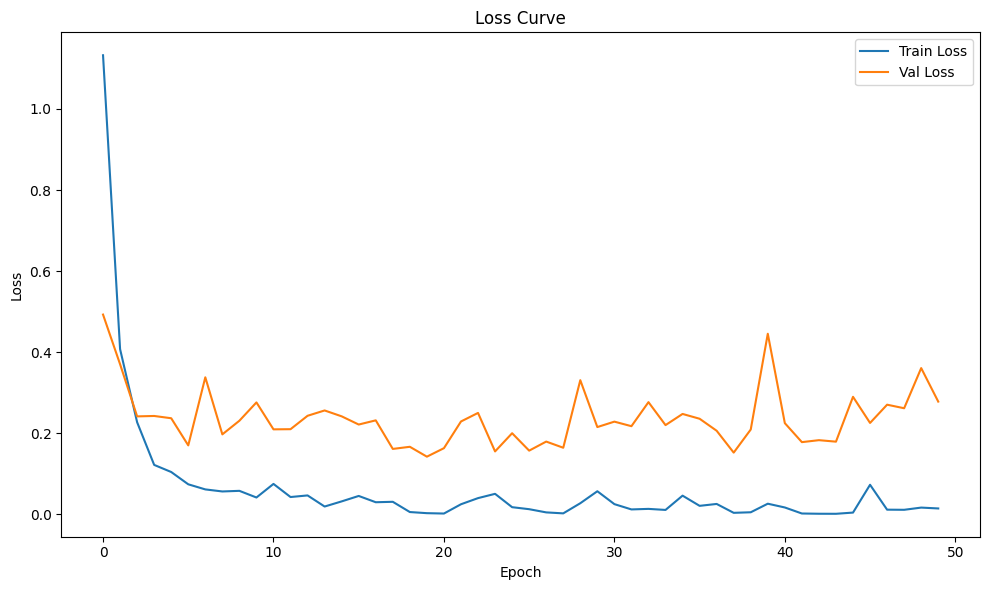

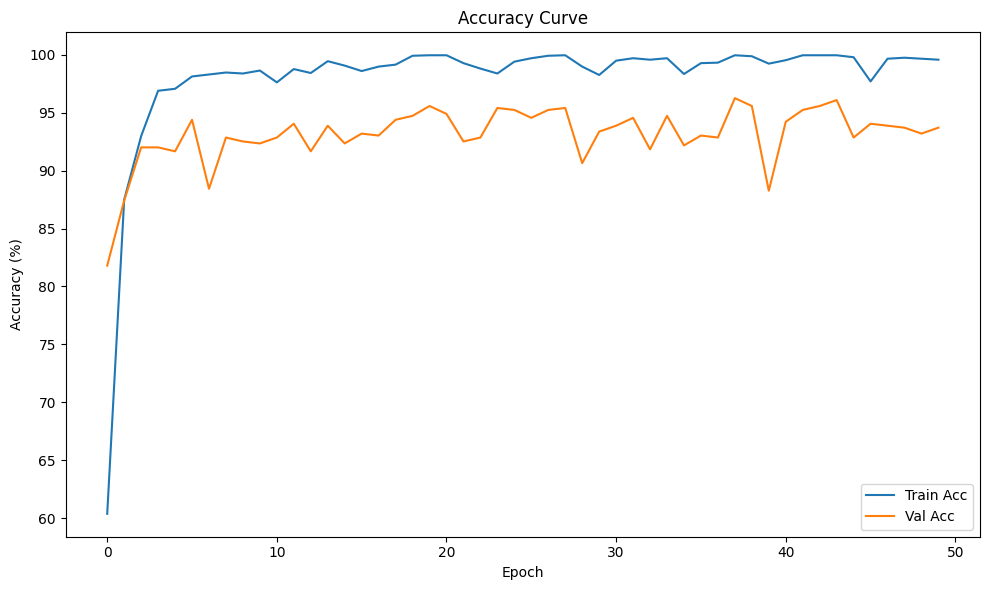

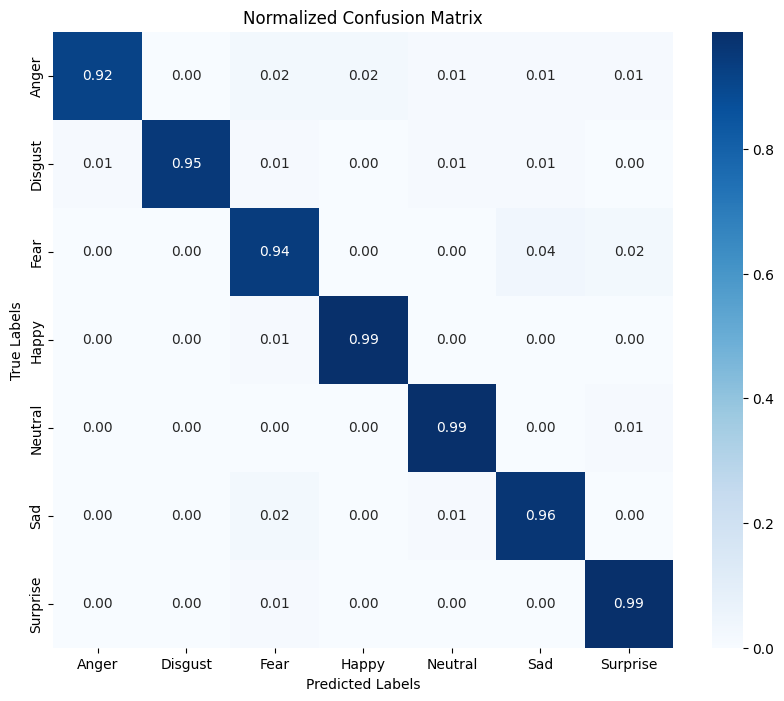

Classification Report:
              precision    recall  f1-score   support

       Anger       0.99      0.92      0.95        84
     Disgust       1.00      0.95      0.98        84
        Fear       0.92      0.94      0.93        84
       Happy       0.98      0.99      0.98        84
     Neutral       0.97      0.99      0.98        84
         Sad       0.94      0.96      0.95        84
    Surprise       0.95      0.99      0.97        84

    accuracy                           0.96       588
   macro avg       0.96      0.96      0.96       588
weighted avg       0.96      0.96      0.96       588



In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Plot Loss and Accuracy
plt.figure(figsize=(10, 6))

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.savefig('Loss.png', dpi=1200)
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.savefig('Acc.png', dpi=1200)
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.savefig('Conf_Mat.png', dpi=1200)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))